In [57]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr


from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings("ignore")

In [58]:
# Load data
sent = pd.read_csv("sentiment.csv", index_col=0, parse_dates=True)
rec  = pd.read_csv("recommendation.csv", index_col=0, parse_dates=True)
price = pd.read_csv("price.csv", index_col=0, parse_dates=True)

print("Original data shapes:")
print(f"Sentiment: {sent.shape}, Recommendation: {rec.shape}, Price: {price.shape}")

# Function to clean data: remove columns >40% NaN (optional), rows >60% NaN, then forward fill
def clean_dataframe(df, name, remove_columns=True):
    original_shape = df.shape
    
    # Step 1: Remove columns with more than 40% NaN (optional, skipped for sentiment)
    if remove_columns:
        col_nan_pct = df.isna().sum() / len(df)
        cols_to_keep = col_nan_pct[col_nan_pct <= 0.4].index
        df_cleaned = df[cols_to_keep].copy()
        cols_removed = len(df.columns) - len(cols_to_keep)
        
        print(f"\n{name} - Step 1 (remove columns >40% NaN):")
        print(f"  Removed {cols_removed} columns ({len(cols_to_keep)} remaining)")
    else:
        df_cleaned = df.copy()
        print(f"\n{name} - Step 1 (skip column removal):")
        print(f"  Keeping all {len(df.columns)} columns")
    
    # Step 2: Remove rows with more than 60% NaN
    row_nan_pct = df_cleaned.isna().sum(axis=1) / len(df_cleaned.columns)
    rows_to_keep = row_nan_pct[row_nan_pct <= 0.6].index
    df_cleaned = df_cleaned.loc[rows_to_keep].copy()
    rows_removed = len(df.index) - len(rows_to_keep)
    
    print(f"{name} - Step 2 (remove rows >60% NaN):")
    print(f"  Removed {rows_removed} rows ({len(rows_to_keep)} remaining)")
    
    # Step 3: Forward fill remaining NaN values (use previous day's value)
    df_cleaned = df_cleaned.ffill()
    
    # If there are still NaN values (e.g., at the start), backward fill
    df_cleaned = df_cleaned.bfill()
    
    remaining_nan = df_cleaned.isna().sum().sum()
    print(f"{name} - Step 3 (forward fill):")
    print(f"  Remaining NaN values: {remaining_nan}")
    print(f"  Final shape: {df_cleaned.shape} (was {original_shape})")
    
    return df_cleaned

# Clean each dataframe
# For sentiment: skip column removal (some stocks started later, keep all columns)
sent = clean_dataframe(sent, "Sentiment", remove_columns=False)
rec = clean_dataframe(rec, "Recommendation", remove_columns=True)
price = clean_dataframe(price, "Price", remove_columns=True)

# Align dataframes on common dates and columns
sent, rec = sent.align(rec, join="inner", axis=0)
sent, price = sent.align(price, join="inner", axis=0)
rec = rec.loc[sent.index]

print(f"\nAfter alignment:")
print(f"Sentiment: {sent.shape}, Recommendation: {rec.shape}, Price: {price.shape}")
print(f"Common dates: {len(sent.index)}")

Original data shapes:
Sentiment: (457, 50), Recommendation: (282, 51), Price: (322, 51)

Sentiment - Step 1 (skip column removal):
  Keeping all 50 columns
Sentiment - Step 2 (remove rows >60% NaN):
  Removed 19 rows (438 remaining)
Sentiment - Step 3 (forward fill):
  Remaining NaN values: 876
  Final shape: (438, 50) (was (457, 50))

Recommendation - Step 1 (remove columns >40% NaN):
  Removed 4 columns (47 remaining)
Recommendation - Step 2 (remove rows >60% NaN):
  Removed 0 rows (282 remaining)
Recommendation - Step 3 (forward fill):
  Remaining NaN values: 0
  Final shape: (282, 47) (was (282, 51))

Price - Step 1 (remove columns >40% NaN):
  Removed 3 columns (48 remaining)
Price - Step 2 (remove rows >60% NaN):
  Removed 1 rows (321 remaining)
Price - Step 3 (forward fill):
  Remaining NaN values: 0
  Final shape: (321, 48) (was (322, 51))

After alignment:
Sentiment: (269, 50), Recommendation: (269, 47), Price: (269, 48)
Common dates: 269


In [59]:
# Sentiment features - multiple windows and transformations
f_sent1 = sent.add_suffix("_s1")
f_sent3 = sent.rolling(3).mean().add_suffix("_s3")
f_sent7 = sent.rolling(7).mean().add_suffix("_s7")
f_sent14 = sent.rolling(14).mean().add_suffix("_s14")
f_sent_std = sent.rolling(7).std().add_suffix("_s_std")  # Sentiment volatility
f_sent_change = sent.diff().add_suffix("_s_change")  # Change in sentiment

# Recommendation features
f_rec1 = rec.add_suffix("_r1")
f_rec3 = rec.rolling(3).mean().add_suffix("_r3")
f_rec7 = rec.rolling(7).mean().add_suffix("_r7")
f_rec_change = rec.diff().add_suffix("_r_change")  # Change in recommendations

# Price-based momentum features
# Calculate returns once for features
price_returns = price.pct_change(fill_method=None)
mom1 = price_returns.add_suffix("_mom1")
mom5 = price.pct_change(5, fill_method=None).add_suffix("_mom5")
mom10 = price.pct_change(10, fill_method=None).add_suffix("_mom10")
mom21 = price.pct_change(21, fill_method=None).add_suffix("_mom21")
mom63 = price.pct_change(63, fill_method=None).add_suffix("_mom63")  # 3-month momentum

# Volatility features
vol5 = price_returns.rolling(5).std().add_suffix("_vol5")
vol10 = price_returns.rolling(10).std().add_suffix("_vol10")
vol21 = price_returns.rolling(21).std().add_suffix("_vol21")

# RSI-like features (relative strength)
def rsi_like(series, window=14):
    """RSI-like indicator: (avg gain - avg loss) / (avg gain + avg loss)"""
    delta = series.pct_change(fill_method=None)
    gain = delta.where(delta > 0, 0).rolling(window).mean()
    loss = -delta.where(delta < 0, 0).rolling(window).mean()
    rs = gain / (loss + 1e-10)
    return (rs - 1) / (rs + 1)

rsi14 = price.apply(lambda x: rsi_like(x, 14)).add_suffix("_rsi14")
rsi7 = price.apply(lambda x: rsi_like(x, 7)).add_suffix("_rsi7")

# Mean reversion features
price_ma5 = price.rolling(5).mean()
price_ma21 = price.rolling(21).mean()
price_ma63 = price.rolling(63).mean()
zscore5 = ((price - price_ma5) / (price.rolling(5).std() + 1e-10)).add_suffix("_zscore5")
zscore21 = ((price - price_ma21) / (price.rolling(21).std() + 1e-10)).add_suffix("_zscore21")

# Relative features (stock vs market)
market_sent = sent.mean(axis=1)
market_rec = rec.mean(axis=1)
market_ret = price_returns.mean(axis=1)

sent_rel = sent.sub(market_sent, axis=0).add_suffix("_sent_rel")
rec_rel = rec.sub(market_rec, axis=0).add_suffix("_rec_rel")
ret_rel = price_returns.sub(market_ret, axis=0).add_suffix("_ret_rel")

In [60]:
# Combine all features
features = pd.concat([
    f_sent1, f_sent3, f_sent7, f_sent14, f_sent_std, f_sent_change,
    f_rec1, f_rec3, f_rec7, f_rec_change,
    mom1, mom5, mom10, mom21, mom63,
    vol5, vol10, vol21,
    rsi7, rsi14,
    zscore5, zscore21,
    sent_rel, rec_rel, ret_rel
], axis=1)

# Lag all features by 1 day to avoid look-ahead bias
# This ensures we use yesterday's features to predict tomorrow's return
features_lagged = features.shift(1)

# Target: next day's return (shift(-1) means tomorrow's return)
# We want to predict: return from today to tomorrow
target_returns = price.pct_change(fill_method=None).shift(-1)

# Debug: Check feature statistics
print(f"Features shape: {features_lagged.shape}")
print(f"Features with NaN: {features_lagged.isna().sum().sum()}")
print(f"Features non-NaN count: {features_lagged.notna().sum().sum()}")
print(f"Sample feature columns: {list(features_lagged.columns[:5])}")
print(f"\nTarget returns shape: {target_returns.shape}")
print(f"Target returns NaN count: {target_returns.isna().sum().sum()}")
print(f"Target returns stats: mean={target_returns.stack().mean():.6f}, std={target_returns.stack().std():.6f}")


Features shape: (269, 1209)
Features with NaN: 15368
Features non-NaN count: 309853
Sample feature columns: ['1COVG.DE_s1', 'AALB.AS_s1', 'ABB.ST_s1', 'ABI.BR_s1', 'ABNd.AS_s1']

Target returns shape: (269, 48)
Target returns NaN count: 48
Target returns stats: mean=0.005318, std=0.533568


In [61]:
# Reshape features for modeling
X = features_lagged.stack().reset_index()
X.columns = ["date", "col", "value"]

# Extract RIC and feature name from column names
# Handle multi-part feature names (e.g., "AAPL_sent_rel")
X["ric"] = X["col"].str.split("_").str[0]
# Join remaining parts as feature name
X["feature_name"] = X["col"].str.split("_", n=1).str[1]

X = X.drop(columns=["col"])

X = X.pivot_table(index=["date","ric"], 
                  columns="feature_name", 
                  values="value")

y = target_returns.stack().reset_index()
y.columns = ["date", "ric", "target"]
y = y.set_index(["date","ric"])

# Align X and y on index before joining
# First, drop rows where target is NaN (these are invalid)
valid_target_mask = ~y["target"].isna()
y_valid = y[valid_target_mask]

# Join X and y - only keep rows where target is valid
df = X.join(y_valid, how="inner")

# Drop rows where target is still NaN
df = df[~df["target"].isna()]

# For features, only drop rows where ALL features are NaN (not just any NaN)
# This is more lenient and preserves more data
feature_cols = [col for col in df.columns if col != "target"]
# Drop rows where all features are NaN
all_features_nan = df[feature_cols].isna().all(axis=1)
df = df[~all_features_nan]

# Fill remaining feature NaN values with column medians (more robust than mean)
for col in feature_cols:
    if df[col].isna().sum() > 0:
        median_val = df[col].median()
        if pd.notna(median_val):
            df[col] = df[col].fillna(median_val)
        else:
            # If median is also NaN, fill with 0
            df[col] = df[col].fillna(0)

print(f"\nAfter joining and cleaning NaN:")
print(f"DataFrame shape: {df.shape}")
print(f"Target stats: mean={df['target'].mean():.6f}, std={df['target'].std():.6f}")
print(f"Target NaN count: {df['target'].isna().sum()}")
print(f"Feature columns: {len(feature_cols)}")
print(f"Rows with any feature NaN: {df[feature_cols].isna().any(axis=1).sum()}")

# Remove extreme outliers more conservatively
# Only remove if it's clearly an error (beyond 5 std for features, 10 std for target)
feature_cols = [col for col in df.columns if col != "target"]
mask = pd.Series(True, index=df.index)

for col in feature_cols:
    mean = df[col].mean()
    std = df[col].std()
    if std > 0:  # Avoid division by zero
        # Use 5 std instead of 3, and only if it doesn't remove too much
        col_mask = (df[col] >= mean - 5*std) & (df[col] <= mean + 5*std)
        pct_kept = col_mask.sum() / len(df)
        if pct_kept > 0.99:  # Only remove if we keep >99% of data
            mask = mask & col_mask

df = df[mask]

# Remove extreme target outliers (beyond 10 std)
target_mean = df["target"].mean()
target_std = df["target"].std()
if target_std > 0:
    target_mask = (df["target"] >= target_mean - 10*target_std) & (df["target"] <= target_mean + 10*target_std)
    df = df[target_mask]

print(f"\nAfter outlier removal:")
print(f"DataFrame shape: {df.shape}")
print(f"Remaining samples: {len(df)}")

X_mat = df.drop(columns=["target"])
y_vec = df["target"]

# Final check
print(f"\nFinal X_mat shape: {X_mat.shape}")
print(f"X_mat NaN count: {X_mat.isna().sum().sum()}")
print(f"X_mat constant columns: {(X_mat.nunique() == 1).sum()}")
print(f"y_vec NaN count: {y_vec.isna().sum()}")
print(f"y_vec stats: mean={y_vec.mean():.6f}, std={y_vec.std():.6f}")


After joining and cleaning NaN:
DataFrame shape: (12816, 26)
Target stats: mean=0.005349, std=0.534566
Target NaN count: 0
Feature columns: 25
Rows with any feature NaN: 0

After outlier removal:
DataFrame shape: (12703, 26)
Remaining samples: 12703

Final X_mat shape: (12703, 25)
X_mat NaN count: 0
X_mat constant columns: 0
y_vec NaN count: 0
y_vec stats: mean=0.000647, std=0.022308


## LASSO REGRESSION

In [62]:
# Check data before modeling
print(f"\nBefore LASSO modeling:")
print(f"X_mat shape: {X_mat.shape}")
print(f"y_vec shape: {y_vec.shape}")
print(f"X_mat NaN count: {X_mat.isna().sum().sum()}")
print(f"y_vec NaN count: {y_vec.isna().sum()}")
print(f"X_mat constant columns: {(X_mat.nunique() == 1).sum()}")
print(f"X_mat columns with variance: {(X_mat.std() > 1e-10).sum()}")

# Remove constant features before modeling
constant_cols = X_mat.columns[X_mat.nunique() == 1]
if len(constant_cols) > 0:
    print(f"Removing {len(constant_cols)} constant features")
    X_mat = X_mat.drop(columns=constant_cols)

if X_mat.shape[1] == 0:
    print("ERROR: No valid features after removing constants!")
else:
    model = LassoCV(cv=min(5, len(X_mat)//10), n_alphas=100, max_iter=2000)
    model.fit(X_mat, y_vec)
    
    pred = model.predict(X_mat)
    df["predicted_return"] = pred
    
    # Calculate market return from target returns (next day's returns, averaged across stocks)
    market_ret = target_returns.mean(axis=1)
    df["market"] = df.index.get_level_values("date").map(market_ret)
    df["alpha"] = df["predicted_return"] - df["market"]
    
    # Debug: Check predictions
    print(f"\nAfter LASSO modeling:")
    print(f"Prediction stats: mean={df['predicted_return'].mean():.6f}, std={df['predicted_return'].std():.6f}")
    print(f"Target stats: mean={df['target'].mean():.6f}, std={df['target'].std():.6f}")
    print(f"Market return stats: mean={df['market'].mean():.6f}, std={df['market'].std():.6f}")
    print(f"Non-zero coefficients: {(model.coef_ != 0).sum()} out of {len(model.coef_)}")


Before LASSO modeling:
X_mat shape: (12703, 25)
y_vec shape: (12703,)
X_mat NaN count: 0
y_vec NaN count: 0
X_mat constant columns: 0
X_mat columns with variance: 25

After LASSO modeling:
Prediction stats: mean=0.000647, std=0.000000
Target stats: mean=0.000647, std=0.022308
Market return stats: mean=0.005306, std=0.075349
Non-zero coefficients: 1 out of 25


In [63]:
# Calculate IC with proper NaN handling
pred_std = df["predicted_return"].std()
target_std = df["target"].std()

if pred_std > 1e-10 and target_std > 1e-10:
    ic = np.corrcoef(df["predicted_return"], df["target"])[0, 1]
    if np.isnan(ic):
        # Try Spearman if Pearson fails
        ic = spearmanr(df["predicted_return"], df["target"])[0]
    print(f"IC: {ic:.6f}")
else:
    print(f"IC: NaN (pred_std={pred_std:.10f}, target_std={target_std:.10f})")
    ic = np.nan

IC: NaN (pred_std=0.0000000000, target_std=0.0223078199)


In [64]:
accuracy = ((df["predicted_return"] > 0) 
            == (df["target"] > 0)).mean()

print("Directional accuracy:", accuracy)


Directional accuracy: 0.5142879634731953


## XGBOOST

In [65]:
tscv = TimeSeriesSplit(n_splits=5)

preds = []
actuals = []
fold_ics = []

print("Training XGBOOST with improved features and hyperparameters...")
print("-" * 60)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_mat), 1):
    X_train, X_test = X_mat.iloc[train_idx], X_mat.iloc[test_idx]
    y_train, y_test = y_vec.iloc[train_idx], y_vec.iloc[test_idx]
    
    # Check for issues
    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Fold {fold}: Empty train or test set!")
        continue
    
    # Remove constant features
    constant_cols = X_train.columns[X_train.nunique() == 1]
    if len(constant_cols) > 0:
        X_train = X_train.drop(columns=constant_cols)
        X_test = X_test.drop(columns=constant_cols)
    
    if X_train.shape[1] == 0:
        print(f"Fold {fold}: No valid features after removing constants!")
        continue
    
    # Further split training data for validation
    split_point = int(len(X_train) * 0.9)
    if split_point == 0:
        split_point = len(X_train)
    X_train_fit, X_val = X_train.iloc[:split_point], X_train.iloc[split_point:]
    y_train_fit, y_val = y_train.iloc[:split_point], y_train.iloc[split_point:]

    # Use a reasonable fixed number of estimators with strong regularization
    # This avoids early stopping compatibility issues across XGBoost versions
    xgb = XGBRegressor(
        n_estimators=500,  # Fixed number - regularization prevents overfitting
        max_depth=5,  # Slightly deeper for more complex patterns
        learning_rate=0.01,  # Lower learning rate for better generalization
        subsample=0.85,  # Slightly higher subsample
        colsample_bytree=0.85,  # Feature subsampling
        colsample_bylevel=0.85,  # Additional regularization
        min_child_weight=3,  # Regularization
        gamma=0.1,  # Minimum loss reduction for splits
        reg_alpha=0.1,  # L1 regularization
        reg_lambda=1.0,  # L2 regularization
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    
    # Fit model - use validation set for monitoring but don't rely on early stopping
    try:
        if len(X_val) > 0:
            xgb.fit(
                X_train_fit, y_train_fit,
                eval_set=[(X_val, y_val)],
                verbose=False
            )
        else:
            xgb.fit(X_train_fit, y_train_fit, verbose=False)
    except Exception as e:
        print(f"Fold {fold}: Error fitting model: {e}")
        continue
    
    best_iter = 500  # Fixed number of estimators used
    
    fold_preds = xgb.predict(X_test)
    preds.extend(fold_preds)
    actuals.extend(y_test)
    
    # Calculate IC with robust NaN handling
    fold_preds_array = np.array(fold_preds)
    y_test_array = np.array(y_test)
    
    # Remove any NaN values
    valid_mask = ~(np.isnan(fold_preds_array) | np.isnan(y_test_array))
    pred_std = 0.0
    target_std = 0.0
    
    if valid_mask.sum() < 2:
        fold_ic = np.nan
        fold_ic_spearman = np.nan
    else:
        fold_preds_clean = fold_preds_array[valid_mask]
        y_test_clean = y_test_array[valid_mask]
        
        # Check for sufficient variance
        pred_std = np.std(fold_preds_clean)
        target_std = np.std(y_test_clean)
        
        if pred_std > 1e-10 and target_std > 1e-10 and len(fold_preds_clean) > 1:
            try:
                # Try Pearson correlation first
                fold_ic = np.corrcoef(fold_preds_clean, y_test_clean)[0, 1]
                if np.isnan(fold_ic) or np.isinf(fold_ic):
                    # Fall back to Spearman
                    fold_ic = spearmanr(fold_preds_clean, y_test_clean)[0]
                    fold_ic_spearman = fold_ic
                else:
                    # Also calculate Spearman for comparison
                    fold_ic_spearman = spearmanr(fold_preds_clean, y_test_clean)[0]
            except Exception as e:
                fold_ic = np.nan
                fold_ic_spearman = np.nan
        else:
            fold_ic = np.nan
            fold_ic_spearman = np.nan
    
    fold_ics.append(fold_ic)
    
    # Print detailed fold information
    if not np.isnan(fold_ic):
        print(f"Fold {fold} IC: {fold_ic:.6f} (Spearman: {fold_ic_spearman:.6f}, test_size: {len(X_test)}, valid: {valid_mask.sum()})")
    else:
        print(f"Fold {fold} IC: NaN (test_size: {len(X_test)}, pred_std: {pred_std:.6f}, target_std: {target_std:.6f}, valid: {valid_mask.sum()})")

print("-" * 60)
if len(preds) > 1 and np.std(preds) > 0 and np.std(actuals) > 0:
    ic_oos = np.corrcoef(preds, actuals)[0, 1]
    if np.isnan(ic_oos):
        ic_oos = spearmanr(preds, actuals)[0]
else:
    ic_oos = np.nan

print(f"Overall IC out-of-sample: {ic_oos:.6f}")
valid_fold_ics = [ic for ic in fold_ics if not np.isnan(ic)]
if len(valid_fold_ics) > 0:
    print(f"Mean fold IC: {np.mean(valid_fold_ics):.6f}")
    print(f"Std fold IC: {np.std(valid_fold_ics):.6f}")
else:
    print("Mean fold IC: NaN (all folds had NaN IC)")

# Calculate additional metrics
preds_array = np.array(preds)
actuals_array = np.array(actuals)
if len(preds_array) > 0:
    directional_accuracy = ((preds_array > 0) == (actuals_array > 0)).mean()
    print(f"Directional accuracy: {directional_accuracy:.4f}")
    
    # Rank IC (correlation of ranks)
    if len(preds_array) > 1:
        rank_ic = spearmanr(preds_array, actuals_array)[0]
        print(f"Rank IC (Spearman): {rank_ic:.6f}")
    
    # Debug info
    print(f"\nPredictions stats: mean={np.mean(preds_array):.6f}, std={np.std(preds_array):.6f}")
    print(f"Actuals stats: mean={np.mean(actuals_array):.6f}, std={np.std(actuals_array):.6f}")
    print(f"Unique predictions: {len(np.unique(preds_array))}")

Training XGBOOST with improved features and hyperparameters...
------------------------------------------------------------
Fold 1 IC: NaN (test_size: 2117, pred_std: 0.000000, target_std: 0.022672, valid: 2117)
Fold 2 IC: NaN (test_size: 2117, pred_std: 0.000000, target_std: 0.028516, valid: 2117)
Fold 3 IC: NaN (test_size: 2117, pred_std: 0.000000, target_std: 0.018933, valid: 2117)
Fold 4 IC: NaN (test_size: 2117, pred_std: 0.000000, target_std: 0.021918, valid: 2117)
Fold 5 IC: NaN (test_size: 2117, pred_std: 0.000000, target_std: 0.021768, valid: 2117)
------------------------------------------------------------
Overall IC out-of-sample: 0.045906
Mean fold IC: NaN (all folds had NaN IC)
Directional accuracy: 0.5246
Rank IC (Spearman): 0.049950

Predictions stats: mean=0.000370, std=0.000291
Actuals stats: mean=0.000833, std=0.023011
Unique predictions: 5


In [66]:
# Feature importance analysis
# Train a final model on all data (except last fold) to get feature importance
final_train_idx = list(tscv.split(X_mat))[-1][0]  # Use all but last fold for training
X_train_final = X_mat.iloc[final_train_idx].copy()
y_train_final = y_vec.iloc[final_train_idx].copy()

# Remove constant features
constant_cols = X_train_final.columns[X_train_final.nunique() == 1]
if len(constant_cols) > 0:
    print(f"Removing {len(constant_cols)} constant features for feature importance analysis")
    X_train_final = X_train_final.drop(columns=constant_cols)

if X_train_final.shape[1] == 0:
    print("No valid features for feature importance analysis!")
else:
    split_point = int(len(X_train_final) * 0.9)
    if split_point == 0:
        split_point = len(X_train_final)
    X_train_fit_final, X_val_final = X_train_final.iloc[:split_point], X_train_final.iloc[split_point:]
    y_train_fit_final, y_val_final = y_train_final.iloc[:split_point], y_train_final.iloc[split_point:]

    xgb_final = XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.85,
        colsample_bytree=0.85,
        colsample_bylevel=0.85,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    # Fit model
    try:
        if len(X_val_final) > 0:
            xgb_final.fit(
                X_train_fit_final, y_train_fit_final,
                eval_set=[(X_val_final, y_val_final)],
                verbose=False
            )
        else:
            xgb_final.fit(X_train_fit_final, y_train_fit_final, verbose=False)
        
        # Get feature importance
        feature_importance = pd.DataFrame({
            'feature': X_train_final.columns,
            'importance': xgb_final.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 20 Most Important Features:")
        print("=" * 60)
        print(feature_importance.head(20).to_string(index=False))
        
        # Show features with zero importance
        zero_importance = feature_importance[feature_importance['importance'] == 0]
        if len(zero_importance) > 0:
            print(f"\nFeatures with zero importance: {len(zero_importance)}")
    except Exception as e:
        print(f"Error in feature importance analysis: {e}")



Top 20 Most Important Features:
 feature  importance
    mom1         0.0
      s1         0.0
zscore21         0.0
    vol5         0.0
   vol21         0.0
   vol10         0.0
sent_rel         0.0
   s_std         0.0
s_change         0.0
      s7         0.0
      s3         0.0
     s14         0.0
    rsi7         0.0
   mom10         0.0
   rsi14         0.0
 ret_rel         0.0
 rec_rel         0.0
r_change         0.0
      r7         0.0
      r3         0.0

Features with zero importance: 25


## BACKTESTING


In [67]:
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# Get unique dates and split into train (~10 months) and test
unique_dates = sorted(df.index.get_level_values("date").unique())
total_days = len(unique_dates)
train_days = int(total_days * (10/12))  # ~10 months out of 12

train_end_date = unique_dates[train_days - 1]
test_start_date = unique_dates[train_days]

print(f"Total dates: {len(unique_dates)}")
print(f"Train period: {unique_dates[0].date()} to {train_end_date.date()} ({train_days} days)")

# Set test period end date (cut off at 2025-10-14)
test_end_date = pd.Timestamp('2025-10-14')
actual_test_end = min(unique_dates[-1], test_end_date)
test_days_in_period = len([d for d in unique_dates if d >= test_start_date and d <= test_end_date])
print(f"Test period: {test_start_date.date()} to {actual_test_end.date()} ({test_days_in_period} days, cutoff at {test_end_date.date()})")

# Split data
train_mask = df.index.get_level_values("date") <= train_end_date
test_mask = (df.index.get_level_values("date") >= test_start_date) & (df.index.get_level_values("date") <= test_end_date)

df_train = df[train_mask].copy()
df_test = df[test_mask].copy()

X_train = df_train.drop(columns=["target", "predicted_return", "market", "alpha"], errors="ignore")
y_train = df_train["target"]
X_test = df_test.drop(columns=["target", "predicted_return", "market", "alpha"], errors="ignore")
y_test = df_test["target"]

print(f"\nTrain samples: {len(df_train)}, Test samples: {len(df_test)}")

# Remove constant features
constant_cols = X_train.columns[X_train.nunique() == 1]
if len(constant_cols) > 0:
    X_train = X_train.drop(columns=constant_cols)
    X_test = X_test.drop(columns=constant_cols)

print(f"Features after removing constants: {X_train.shape[1]}")


Total dates: 267
Train period: 2024-09-02 to 2025-09-02 (222 days)
Test period: 2025-09-03 to 2025-10-14 (23 days, cutoff at 2025-10-14)

Train samples: 10551, Test samples: 1100
Features after removing constants: 25


In [68]:
# Train model - can switch between Lasso and XGBoost
# Set model_type = "lasso" or "xgboost"
# 
# TO SWITCH MODELS: Change the line below to "lasso" or "xgboost"
model_type = "xgboost"  # <-- CHANGE THIS: "lasso" or "xgboost"

if model_type == "lasso":
    print("Training LASSO model...")
    model = LassoCV(cv=min(5, len(X_train)//10), n_alphas=100, max_iter=2000)
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    
elif model_type == "xgboost":
    print("Training XGBoost model...")
    # Split training data for validation
    split_point = int(len(X_train) * 0.9)
    if split_point == 0:
        split_point = len(X_train)
    X_train_fit, X_val = X_train.iloc[:split_point], X_train.iloc[split_point:]
    y_train_fit, y_val = y_train.iloc[:split_point], y_train.iloc[split_point:]
    
    xgb = XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.85,
        colsample_bytree=0.85,
        colsample_bylevel=0.85,
        min_child_weight=3,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    
    if len(X_val) > 0:
        xgb.fit(X_train_fit, y_train_fit, eval_set=[(X_val, y_val)], verbose=False)
    else:
        xgb.fit(X_train_fit, y_train_fit, verbose=False)
    
    model = xgb
    test_pred = model.predict(X_test)

# Create predictions dataframe for test period
df_test_pred = df_test.copy()
df_test_pred["predicted_return"] = test_pred

# Calculate market return for test period
market_ret_test = target_returns.loc[df_test_pred.index.get_level_values("date").unique()].mean(axis=1)
df_test_pred["market"] = df_test_pred.index.get_level_values("date").map(market_ret_test)
df_test_pred["alpha"] = df_test_pred["predicted_return"] - df_test_pred["market"]

print(f"\nTest predictions stats:")
print(f"  Mean predicted return: {df_test_pred['predicted_return'].mean():.6f}")
print(f"  Std predicted return: {df_test_pred['predicted_return'].std():.6f}")
print(f"  Mean alpha: {df_test_pred['alpha'].mean():.6f}")
print(f"  Std alpha: {df_test_pred['alpha'].std():.6f}")


Training XGBoost model...

Test predictions stats:
  Mean predicted return: 0.000530
  Std predicted return: 0.000000
  Mean alpha: -0.002383
  Std alpha: 0.007838


In [69]:
# Calculate portfolio returns
# 
# STRATEGY EXPLANATION:
# =====================
# The model predicts ALPHA for each stock individually (per company)
# - Alpha = predicted return - market return
# - If alpha > 0: Stock predicted to outperform market → GO LONG (buy)
# - If alpha < 0: Stock predicted to underperform market → GO SHORT (sell)
#
# PORTFOLIO CONSTRUCTION:
# - We start with $1 total capital
# - Each day, we look at all available stocks (typically ~48 stocks)
# - For each stock, we decide: LONG if alpha > 0, SHORT if alpha < 0
# - We split our $1 capital: 50% goes to long positions, 50% to short positions (dollar-neutral)
# - Within long positions: equal weight across all stocks with positive alpha
# - Within short positions: equal weight across all stocks with negative alpha
#
# EXAMPLE:
# - Day 1: 30 stocks have positive alpha, 18 have negative alpha
#   - Long: $0.50 split equally among 30 stocks = $0.50/30 = $0.0167 per stock
#   - Short: $0.50 split equally among 18 stocks = $0.50/18 = $0.0278 per stock
#   - If long stocks go up 2% and short stocks go down 1%:
#     - Long return: 0.02
#     - Short return: -(-0.01) = 0.01 (we profit when shorted stocks go down)
#     - Total return: 0.5 * 0.02 + 0.5 * 0.01 = 0.015 (1.5%)

# Get unique dates in test period (up to cutoff date)
test_dates = sorted([d for d in df_test_pred.index.get_level_values("date").unique() if d <= test_end_date])

# Initialize portfolio values
fama_macbeth_portfolio = 1.0  # Fama-MacBeth cross-sectional regression baseline
alpha_longshort_portfolio = 1.0  # Long/short based on alpha
buy_hold_portfolio = 1.0  # Buy-and-hold: equal weight all stocks

fama_macbeth_returns = []
alpha_longshort_returns = []
buy_hold_returns = []
portfolio_dates = []

# Debug: Check alpha variation
print(f"\nDebug: Checking alpha variation across test period...")
sample_date = test_dates[0] if len(test_dates) > 0 else None
if sample_date:
    sample_alphas = df_test_pred.loc[df_test_pred.index.get_level_values("date") == sample_date]["alpha"].values
    print(f"  Sample date {sample_date.date()}: {len(sample_alphas)} stocks")
    print(f"  Alpha stats: mean={sample_alphas.mean():.6f}, std={sample_alphas.std():.6f}, min={sample_alphas.min():.6f}, max={sample_alphas.max():.6f}")
    print(f"  Positive alphas: {(sample_alphas > 0).sum()}, Negative alphas: {(sample_alphas < 0).sum()}")

# For each date, calculate portfolio returns
for date_idx, date in enumerate(test_dates):
    date_data = df_test_pred.loc[df_test_pred.index.get_level_values("date") == date]
    
    if len(date_data) == 0:
        continue
    
    # Get actual returns and alphas for this date
    actual_returns = date_data["target"].values
    alphas = date_data["alpha"].values
    n_stocks = len(date_data)
    
    # BASELINE: Fama-MacBeth Cross-Sectional Regression
    # Use historical data (up to but not including today) to fit model, then predict today
    # This avoids look-ahead bias - we don't use today's returns to fit the model
    date_features = X_test.loc[date_data.index]  # Features for this date
    
    if len(date_features) > 1 and date_features.shape[1] > 0:
        # Get historical data: training data + previous test dates
        historical_features_list = []
        historical_returns_list = []
        
        # Add training data
        if len(X_train) > 0:
            historical_features_list.append(X_train)
            historical_returns_list.append(y_train)
        
        # Add previous test dates (if any)
        if date_idx > 0:
            prev_test_dates = test_dates[:date_idx]
            for prev_date in prev_test_dates:
                prev_data = df_test.loc[df_test.index.get_level_values("date") == prev_date]
                if len(prev_data) > 0:
                    prev_features = X_test.loc[prev_data.index]
                    prev_returns = y_test.loc[prev_data.index]
                    historical_features_list.append(prev_features)
                    historical_returns_list.append(prev_returns)
        
        # Combine historical data
        if len(historical_features_list) > 0:
            historical_features = pd.concat(historical_features_list)
            historical_returns = pd.concat(historical_returns_list)
            
            # Check for sufficient variation and data points
            if len(historical_features) > 10 and historical_features.std().sum() > 1e-10:
                # Fit model on historical data
                fm_model = LinearRegression()
                try:
                    fm_model.fit(historical_features, historical_returns)
                    # Predict on today's features (out-of-sample, no look-ahead bias)
                    fm_predicted_returns = fm_model.predict(date_features)
                    
                    # Use predicted returns to form long/short portfolio
                    fm_pred_median = np.median(fm_predicted_returns)
                    fm_long_mask = fm_predicted_returns > fm_pred_median
                    fm_short_mask = fm_predicted_returns <= fm_pred_median
                    
                    n_fm_long = fm_long_mask.sum()
                    n_fm_short = fm_short_mask.sum()
                    
                    if n_fm_long > 0 and n_fm_short > 0:
                        # Dollar-neutral: 50% long, 50% short
                        fm_long_weights = np.ones(n_fm_long) / (2 * n_fm_long)
                        fm_short_weights = -np.ones(n_fm_short) / (2 * n_fm_short)
                        fm_long_return = (fm_long_weights * actual_returns[fm_long_mask]).sum()
                        fm_short_return = (fm_short_weights * actual_returns[fm_short_mask]).sum()
                        fama_macbeth_return = fm_long_return + fm_short_return
                    elif n_fm_long > 0:
                        fm_long_weights = np.ones(n_fm_long) / n_fm_long
                        fama_macbeth_return = (fm_long_weights * actual_returns[fm_long_mask]).sum()
                    elif n_fm_short > 0:
                        fm_short_weights = -np.ones(n_fm_short) / n_fm_short
                        fama_macbeth_return = -(fm_short_weights * actual_returns[fm_short_mask]).sum()
                    else:
                        fama_macbeth_return = 0.0
                except:
                    # If regression fails, use equal weight
                    fama_macbeth_return = actual_returns.mean()
            else:
                # Not enough historical data, use equal weight
                fama_macbeth_return = actual_returns.mean()
        else:
            # No historical data, use equal weight
            fama_macbeth_return = actual_returns.mean()
    else:
        # Not enough data, use equal weight
        fama_macbeth_return = actual_returns.mean()
    
    # ALPHA STRATEGY: Rank by alpha, long top decile, short bottom decile
    # Strategy: Rank all stocks by predicted alpha, go long top 10%, short bottom 10%
    # Daily rebalancing: positions change each day based on new rankings
    
    # Rank stocks by alpha (highest alpha = rank 0, lowest = rank n-1)
    alpha_ranks = np.argsort(np.argsort(-alphas))  # Negative for descending order
    
    # Calculate decile cutoffs
    n_stocks = len(alphas)
    top_decile_size = max(1, int(np.ceil(n_stocks * 0.10)))  # Top 10%, at least 1 stock
    bottom_decile_size = max(1, int(np.ceil(n_stocks * 0.10)))  # Bottom 10%, at least 1 stock
    
    # Top decile: stocks with highest alpha (ranks 0 to top_decile_size-1)
    # Bottom decile: stocks with lowest alpha (ranks n-bottom_decile_size to n-1)
    top_decile_cutoff = top_decile_size
    bottom_decile_cutoff = n_stocks - bottom_decile_size
    
    long_mask = alpha_ranks < top_decile_cutoff  # Top decile
    short_mask = alpha_ranks >= bottom_decile_cutoff  # Bottom decile
    
    n_long = long_mask.sum()
    n_short = short_mask.sum()
    
    # Calculate portfolio return
    if n_long == 0 and n_short == 0:
        # No positions (shouldn't happen)
        alpha_longshort_return = 0.0
    elif n_long == 0:
        # Only short positions
        short_weights = np.ones(n_short) / n_short
        alpha_longshort_return = -(short_weights * actual_returns[short_mask]).sum()
    elif n_short == 0:
        # Only long positions
        long_weights = np.ones(n_long) / n_long
        alpha_longshort_return = (long_weights * actual_returns[long_mask]).sum()
    else:
        # Both long and short positions (typical case)
        # Dollar-neutral: 50% capital to longs, 50% to shorts
        long_weights = np.ones(n_long) / (2 * n_long)  # Each gets 0.5/n_long
        short_weights = -np.ones(n_short) / (2 * n_short)  # Each gets -0.5/n_short
        
        # Calculate returns
        long_return = (long_weights * actual_returns[long_mask]).sum()
        short_return = (short_weights * actual_returns[short_mask]).sum()
        alpha_longshort_return = long_return + short_return
    
    # BUY-AND-HOLD: Equal weight in all stocks (simple baseline)
    # Just the average return of all stocks on this date
    buy_hold_return = actual_returns.mean()
    
    # Update portfolio values
    fama_macbeth_portfolio *= (1 + fama_macbeth_return)
    alpha_longshort_portfolio *= (1 + alpha_longshort_return)
    buy_hold_portfolio *= (1 + buy_hold_return)
    
    fama_macbeth_returns.append(fama_macbeth_return)
    alpha_longshort_returns.append(alpha_longshort_return)
    buy_hold_returns.append(buy_hold_return)
    portfolio_dates.append(date)

# Convert to cumulative returns (start at 1.0)
# Prepend 1.0 so the cumulative returns start at the initial investment of $1
fama_macbeth_cumulative = np.concatenate([[1.0], np.cumprod(1 + np.array(fama_macbeth_returns))])
alpha_longshort_cumulative = np.concatenate([[1.0], np.cumprod(1 + np.array(alpha_longshort_returns))])
buy_hold_cumulative = np.concatenate([[1.0], np.cumprod(1 + np.array(buy_hold_returns))])

# Prepend the first date (or day before) for plotting
# Use the day before the first test date as the starting point
if len(portfolio_dates) > 0:
    start_date = portfolio_dates[0] - timedelta(days=1)
    plot_dates = [start_date] + portfolio_dates
else:
    plot_dates = portfolio_dates

print(f"\nPortfolio performance over {len(portfolio_dates)} trading days:")
print(f"Buy-and-Hold (all stocks): {buy_hold_cumulative[-1]:.4f}x ({((buy_hold_cumulative[-1] - 1) * 100):.2f}%)")
print(f"Fama-MacBeth (baseline): {fama_macbeth_cumulative[-1]:.4f}x ({((fama_macbeth_cumulative[-1] - 1) * 100):.2f}%)")
print(f"Alpha Long/Short ({model_type.upper()}): {alpha_longshort_cumulative[-1]:.4f}x ({((alpha_longshort_cumulative[-1] - 1) * 100):.2f}%)")



Debug: Checking alpha variation across test period...
  Sample date 2025-09-03: 48 stocks
  Alpha stats: mean=-0.004118, std=0.000000, min=-0.004118, max=-0.004118
  Positive alphas: 0, Negative alphas: 48

Portfolio performance over 23 trading days:
Buy-and-Hold (all stocks): 1.0690x (6.90%)
Fama-MacBeth (baseline): 1.0190x (1.90%)
Alpha Long/Short (XGBOOST): 1.0345x (3.45%)



CONCRETE EXAMPLE - How the strategy works on one day:

Date: 2025-09-03
Total stocks available: 48
Top decile (LONG): 5 stocks
Bottom decile (SHORT): 5 stocks
Middle stocks (ignored): 38 stocks

Capital allocation:
  Long positions (top decile): $0.50 total → $0.1000 per stock
  Short positions (bottom decile): $0.50 total → $0.1000 per stock

  TOP DECILE - LONG positions:
    1COVG.DE: alpha=-0.004118, rank=0, actual_return=-0.060727
    AALB.AS: alpha=-0.004118, rank=25, actual_return=0.007687
    AMG.AS: alpha=-0.004118, rank=1, actual_return=-0.030501
    AMUN.PA: alpha=-0.004118, rank=2, actual_return=0.009646
    APAM.AS: alpha=-0.004118, rank=3, actual_return=0.018419

  BOTTOM DECILE - SHORT positions:
    AKRBP.OL: alpha=-0.004118, rank=42, actual_return=-0.008982
      (If this stock goes DOWN, we profit)
    AKZO.AS: alpha=-0.004118, rank=43, actual_return=0.001695
      (If this stock goes DOWN, we profit)
    ALFA.ST: alpha=-0.004118, rank=44, actual_return=-0.007290
   

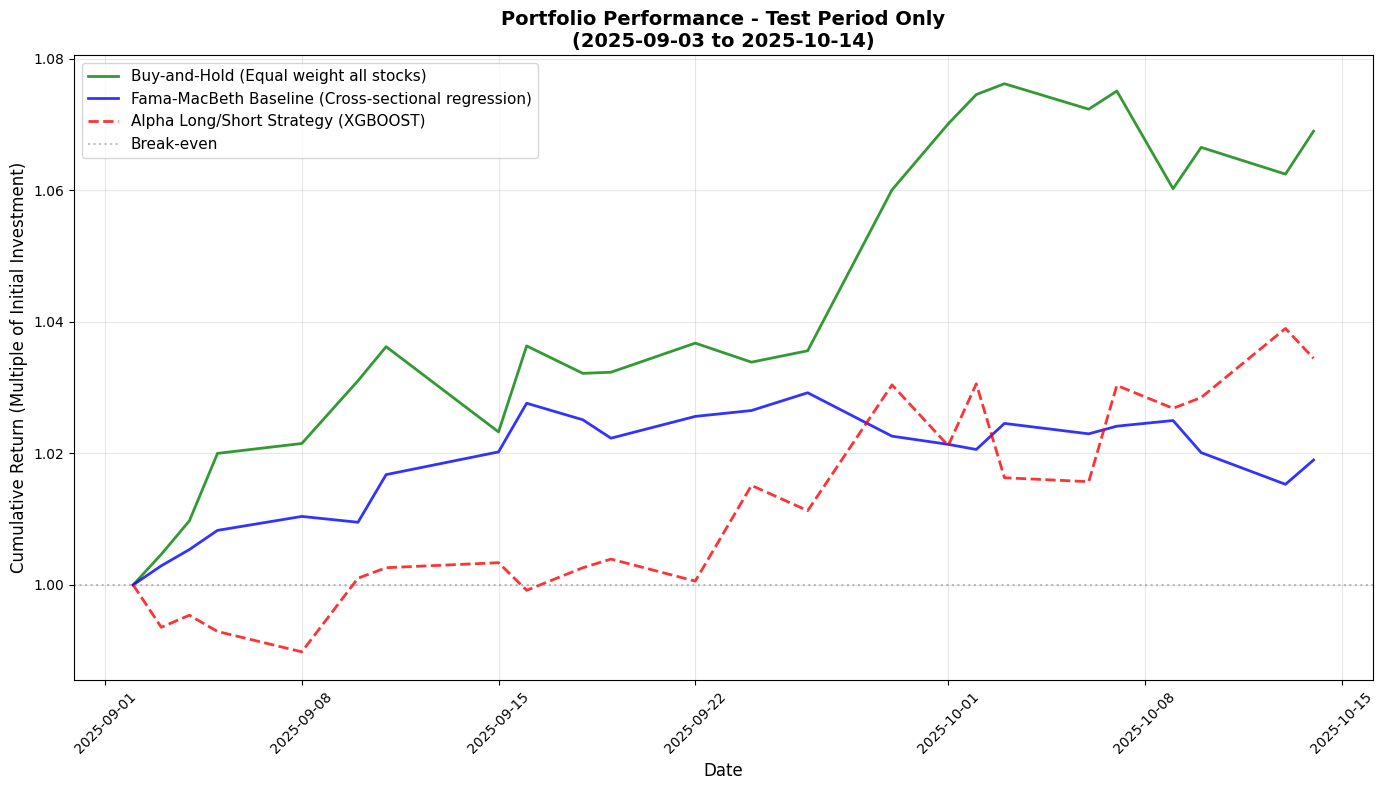


Summary Statistics:
Buy-and-Hold (Equal weight all stocks):
  Final value: $1.0690
  Total return: 6.90%
  Daily return (mean): 0.2936%
  Daily return (std): 0.7796%
  Sharpe ratio (assuming 252 trading days): 5.9775

Fama-MacBeth Baseline (Cross-sectional regression):
  Final value: $1.0190
  Total return: 1.90%
  Daily return (mean): 0.0824%
  Daily return (std): 0.3494%
  Sharpe ratio (assuming 252 trading days): 3.7461

Alpha Long/Short Strategy (XGBOOST):
  Final value: $1.0345
  Total return: 3.45%
  Daily return (mean): 0.1506%
  Daily return (std): 0.7991%
  Sharpe ratio (assuming 252 trading days): 2.9907

Outperformance vs Fama-MacBeth:
  Absolute: 0.0155x (1.52%)


In [70]:
# Print a concrete example for one day to illustrate the strategy
print("\n" + "="*60)
print("CONCRETE EXAMPLE - How the strategy works on one day:")
print("="*60)
if len(test_dates) > 0:
    example_date = test_dates[0]
    example_data = df_test_pred.loc[df_test_pred.index.get_level_values("date") == example_date]
    example_alphas = example_data["alpha"].values
    example_returns = example_data["target"].values
    example_rics = example_data.index.get_level_values("ric").values
    
    # Rank by alpha for example
    example_alpha_ranks = np.argsort(np.argsort(-example_alphas))
    n_stocks_ex = len(example_data)
    top_decile_size_ex = max(1, int(np.ceil(n_stocks_ex * 0.10)))
    bottom_decile_size_ex = max(1, int(np.ceil(n_stocks_ex * 0.10)))
    top_decile_cutoff_ex = top_decile_size_ex
    bottom_decile_cutoff_ex = n_stocks_ex - bottom_decile_size_ex
    
    top_decile_mask = example_alpha_ranks < top_decile_cutoff_ex
    bottom_decile_mask = example_alpha_ranks >= bottom_decile_cutoff_ex
    
    n_long_ex = top_decile_mask.sum()
    n_short_ex = bottom_decile_mask.sum()
    
    print(f"\nDate: {example_date.date()}")
    print(f"Total stocks available: {len(example_data)}")
    print(f"Top decile (LONG): {n_long_ex} stocks")
    print(f"Bottom decile (SHORT): {n_short_ex} stocks")
    print(f"Middle stocks (ignored): {n_stocks_ex - n_long_ex - n_short_ex} stocks")
    
    if n_long_ex > 0 and n_short_ex > 0:
        print(f"\nCapital allocation:")
        print(f"  Long positions (top decile): $0.50 total → ${0.50/n_long_ex:.4f} per stock")
        print(f"  Short positions (bottom decile): $0.50 total → ${0.50/n_short_ex:.4f} per stock")
        
        # Show the actual top and bottom decile stocks
        example_data_sorted = example_data.copy()
        example_data_sorted['alpha_rank'] = example_alpha_ranks
        example_data_sorted = example_data_sorted.sort_values('alpha', ascending=False)
        
        top_decile_stocks = example_data_sorted.head(n_long_ex)
        bottom_decile_stocks = example_data_sorted.tail(n_short_ex)
        
        if len(top_decile_stocks) > 0:
            print(f"\n  TOP DECILE - LONG positions:")
            for ric, row in top_decile_stocks.iterrows():
                print(f"    {ric[1]}: alpha={row['alpha']:.6f}, rank={row['alpha_rank']:.0f}, actual_return={row['target']:.6f}")
        
        if len(bottom_decile_stocks) > 0:
            print(f"\n  BOTTOM DECILE - SHORT positions:")
            for ric, row in bottom_decile_stocks.iterrows():
                print(f"    {ric[1]}: alpha={row['alpha']:.6f}, rank={row['alpha_rank']:.0f}, actual_return={row['target']:.6f}")
                print(f"      (If this stock goes DOWN, we profit)")

print("\n" + "="*60)

# Plot portfolio performance
plt.figure(figsize=(14, 8))
plt.plot(plot_dates, buy_hold_cumulative, label="Buy-and-Hold (Equal weight all stocks)", 
         linewidth=2, alpha=0.8, color='green')
plt.plot(plot_dates, fama_macbeth_cumulative, label="Fama-MacBeth Baseline (Cross-sectional regression)", 
         linewidth=2, alpha=0.8, color='blue')
plt.plot(plot_dates, alpha_longshort_cumulative, label=f"Alpha Long/Short Strategy ({model_type.upper()})", 
         linewidth=2, alpha=0.8, linestyle="--", color='red')

plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.5, label='Break-even')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return (Multiple of Initial Investment)", fontsize=12)
if len(portfolio_dates) > 0:
    actual_end_date = min(portfolio_dates[-1], test_end_date)
    plt.title(f"Portfolio Performance - Test Period Only\n({test_start_date.date()} to {actual_end_date.date()})", 
              fontsize=14, fontweight='bold')
else:
    plt.title(f"Portfolio Performance - Test Period Only", 
              fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"=" * 60)
print(f"Buy-and-Hold (Equal weight all stocks):")
print(f"  Final value: ${buy_hold_cumulative[-1]:.4f}")
print(f"  Total return: {((buy_hold_cumulative[-1] - 1) * 100):.2f}%")
print(f"  Daily return (mean): {np.mean(buy_hold_returns)*100:.4f}%")
print(f"  Daily return (std): {np.std(buy_hold_returns)*100:.4f}%")
if np.std(buy_hold_returns) > 1e-10:
    print(f"  Sharpe ratio (assuming 252 trading days): {np.mean(buy_hold_returns) / np.std(buy_hold_returns) * np.sqrt(252):.4f}")
else:
    print(f"  Sharpe ratio: N/A (zero volatility)")

print(f"\nFama-MacBeth Baseline (Cross-sectional regression):")
print(f"  Final value: ${fama_macbeth_cumulative[-1]:.4f}")
print(f"  Total return: {((fama_macbeth_cumulative[-1] - 1) * 100):.2f}%")
print(f"  Daily return (mean): {np.mean(fama_macbeth_returns)*100:.4f}%")
print(f"  Daily return (std): {np.std(fama_macbeth_returns)*100:.4f}%")
if np.std(fama_macbeth_returns) > 1e-10:
    print(f"  Sharpe ratio (assuming 252 trading days): {np.mean(fama_macbeth_returns) / np.std(fama_macbeth_returns) * np.sqrt(252):.4f}")
else:
    print(f"  Sharpe ratio: N/A (zero volatility)")

print(f"\nAlpha Long/Short Strategy ({model_type.upper()}):")
print(f"  Final value: ${alpha_longshort_cumulative[-1]:.4f}")
print(f"  Total return: {((alpha_longshort_cumulative[-1] - 1) * 100):.2f}%")
print(f"  Daily return (mean): {np.mean(alpha_longshort_returns)*100:.4f}%")
print(f"  Daily return (std): {np.std(alpha_longshort_returns)*100:.4f}%")
if np.std(alpha_longshort_returns) > 1e-10:
    print(f"  Sharpe ratio (assuming 252 trading days): {np.mean(alpha_longshort_returns) / np.std(alpha_longshort_returns) * np.sqrt(252):.4f}")
else:
    print(f"  Sharpe ratio: N/A (zero volatility)")

# Calculate outperformance
outperformance = alpha_longshort_cumulative[-1] - fama_macbeth_cumulative[-1]
outperformance_pct = (outperformance / fama_macbeth_cumulative[-1]) * 100 if fama_macbeth_cumulative[-1] > 0 else 0
print(f"\nOutperformance vs Fama-MacBeth:")
print(f"  Absolute: {outperformance:.4f}x ({outperformance_pct:.2f}%)")
